# 1. Setup

### Import dependecies

In [1]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import uuid

In [2]:
# import Tensorflow functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

### Set GPU growth

In [3]:
# Avoid out of memory error by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Create folder structure 

In [4]:
POSITIVE_PATH = os.path.join('data', 'positive')
NEGATIVE_PATH = os.path.join('data', 'negative')
ANCHOR_PATH = os.path.join('data', 'anchor')

# creating directories

# os.makedirs(POSITIVE_PATH)
# os.makedirs(NEGATIVE_PATH)
# os.makedirs(ANCHOR_PATH)

# 2. Collect images

### Untar labelled faces in the wild dataset

In [16]:
# uncompress tar gz file
# !tar -xf lfw.tgz

^C


In [19]:
# move LFW images tothe following repository data/negative

for directory in os.listdir('lfw'):
    file_path = os.path.join('lfw', directory)
    for file in os.listdir(file_path):
        EXISING_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEGATIVE_PATH, file)
        os.replace(EXISING_PATH, NEW_PATH)

### Collect Positive and anchor images

In [22]:
# establishing a connection to webcam

cap = cv2.VideoCapture(0)

while cap.isOpened():
    
    ret, frame = cap.read()
    
    # cut down frame to 250px*250px
    frame = frame[120:120+250, 200:200+250,:]
    
    # collect anchor images
    if cv2.waitKey(1) & 0XFF == ord('a'):
        
        image_name = os.path.join(ANCHOR_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)
    
    # collect positive images
    if cv2.waitKey(1) & 0XFF == ord('p'):
        
        image_name = os.path.join(POSITIVE_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name,frame)
    
    
    # show image back to screen
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

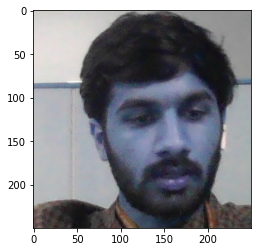

In [23]:
plt.imshow(frame)

# 3. Load Preprocess images

### Get image directories

In [5]:
# To create a dataset of all files matching a pattern, use tf.data.Dataset.list_files:

anchor = tf.data.Dataset.list_files(ANCHOR_PATH + '\*.jpg').take(501)
positive = tf.data.Dataset.list_files(POSITIVE_PATH + '\*.jpg').take(501)
negative = tf.data.Dataset.list_files(NEGATIVE_PATH + '\*.jpg').take(501)

In [6]:
dir_test = anchor.as_numpy_iterator()

In [7]:
dir_test.next()

b'data\\anchor\\76f58402-343a-11ed-b3e1-c8b29b0ea9b0.jpg'

### Preprocessing: Scale and Resize

In [8]:
def preprocess(file_path):
    
    """
        In this function, we first read in the image and then load the image.
        After this we resize the image into 100px * 100px * 3 color channels.
        Last line helps in scaling.
    """
    byte_image = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_image)  # loading of image
    img = tf.image.resize(img, (100,100))
    img = img/255.0
    
    return img

### Create labelled dataset

In [9]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [10]:
samples = data.as_numpy_iterator()

In [11]:
example = samples.next()

### Build train and test partition

In [12]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [13]:
res = preprocess_twin(*example)

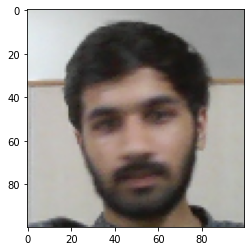

In [14]:
plt.imshow(res[0])

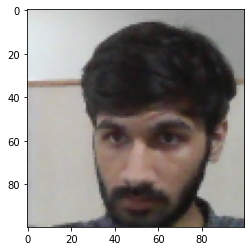

In [15]:
plt.imshow(res[1])

In [16]:
res[2]

1.0

In [17]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [18]:
data_samples = data.as_numpy_iterator()

In [19]:
s = data_samples.next()

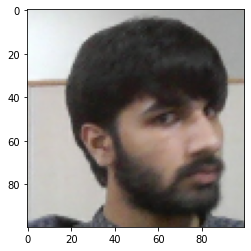

In [20]:
plt.imshow(s[0])

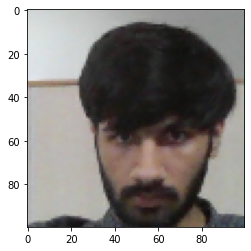

In [21]:
plt.imshow(s[1])

In [22]:
s[2]

1.0

In [23]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

### Build embedding layers

In [ ]:
def make_embedding():
    inp = Input(shape = (100,100,3),name ='input_image')
    
    # First block of model
    
    # we are passing inp as a connecting layer. This is a part of Tensorflow functional API
    c1 = Conv2D(64,(10,10),activation = 'relu')(inp) 
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)
    
    # Second block of model
    c2= Conv2D(128,(7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)
    
    # Third block of model
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)
    
    
    
    return Model(inputs = , outputs = , name = )

### Build distance layer

### Build siamese model